In [1]:
SIZE = 128

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            validation_split = 0.2,
            # rotation_range = 30,
            # width_shift_range = 0.2,
            # height_shift_range = 0.2,
            # shear_range = 0.2,
            # zoom_range = 0.2,
            # fill_mode = 'nearest',
            )

train_gen = datagen.flow_from_directory(
    "Dataset/",
    target_size=(SIZE, SIZE),
    seed = 42,
    batch_size=32,
    shuffle=True,
    subset='training',
    class_mode="input",
)
val_gen = datagen.flow_from_directory(
    "Dataset/",
    target_size=(SIZE, SIZE),
    batch_size=32,
    shuffle=False,
    subset='validation',
    class_mode="input",
)

Found 162080 images belonging to 1 classes.
Found 40519 images belonging to 1 classes.


In [10]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50


def encoder():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers:
        if "conv5_block3" in layer.name:  # Last convolutional block in ResNet50
            layer.trainable = True
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model

def bottleneck():
    inputs = layers.Input(shape=(2048,))
    x = layers.Flatten()(inputs)
    x = layers.Dense(1500, activation="relu")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x,name = "bottleneck")
    return model

def decoder():
    inputs = layers.Input(shape=(1500,))
    x = layers.Dense(4 * 4 * 256, activation="relu")(inputs)
    x = layers.Reshape((4, 4, 256))(x)  
    
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(3, 3, activation="sigmoid", strides=2, padding="same")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x, name = "decoder")
    return model

In [11]:
model = tf.keras.models.Sequential([
    encoder(),
    bottleneck(),
    decoder()
    ])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 2048)              23587712  
                                                                 
 bottleneck (Functional)     (None, 1500)              3073500   
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       6540451   
                                                                 
Total params: 33,201,663
Trainable params: 14,079,615
Non-trainable params: 19,122,048
_________________________________________________________________


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = 'best_model_resnet.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0)
early_stopping = EarlyStopping(
    monitor='loss',
    patience=1,
    
    )
from tqdm.keras import TqdmCallback

In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),loss = tf.keras.losses.MeanSquaredError())
model.fit(train_gen,validation_data = val_gen,steps_per_epoch = 50000//32,validation_steps=50000*0.2//32,epochs = 5,batch_size=32,callbacks = [TqdmCallback(verbose=1),checkpoint_callback,early_stopping],verbose = 0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

KeyboardInterrupt: 

1/1 [==============================] - 0s 24ms/step


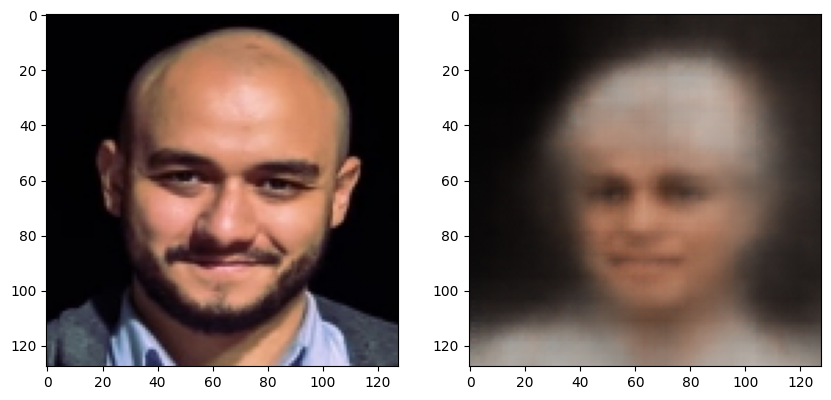

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))


img = cv2.imread("test.jpg",)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(128,128))


img = np.reshape(img,(1,128,128,3))
img = img/255
pred = model.predict(img)

plt.subplot(1, 2, 1)
plt.imshow(img[0], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(pred[0], cmap='gray')

In [38]:
x = decoder()
x.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1500)]            0         
                                                                 
 dense_3 (Dense)             (None, 4096)              6148096   
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 8, 8, 128)        295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 16, 16, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 32, 32, 32)       1846

In [32]:
for i, model_part in enumerate(model.layers):
    print(model_part.name)
    model_part.save(f'{model_part.name}_resnet.keras')

model_4
bottleneck
decoder


In [33]:
def siamese():
    encoder_model_1 = tf.keras.models.load_model("model_4_resnet.keras")
    bottleneck_model_1 = tf.keras.models.load_model("bottleneck_resnet.keras")
    encoder_model_2 = tf.keras.models.load_model("model_4_resnet.keras")
    bottleneck_model_2 = tf.keras.models.load_model("bottleneck_resnet.keras")
    encoder_model_1._name = "encoder_1"
    encoder_model_2._name = "encoder_2"
    bottleneck_model_1._name = "bottleneck_1"
    bottleneck_model_2._name = "bottleneck_2"
    
    
    input1 = tf.keras.Input(shape=encoder_model_1.input_shape[1:])  
    input2 = tf.keras.Input(shape=encoder_model_2.input_shape[1:])
    output1 = encoder_model_1(input1)
    output2 = encoder_model_2(input2)
    bottleneck_output1 = bottleneck_model_1(output1)
    bottleneck_output2 = bottleneck_model_2(output2)
    cosine_similarity = layers.Lambda(lambda tensors: tf.reduce_sum(
        tf.multiply(tensors[0], tensors[1]), axis=-1, keepdims=True
    ) / (tf.sqrt(tf.reduce_sum(tf.square(tensors[0]), axis=-1, keepdims=True)) *
        tf.sqrt(tf.reduce_sum(tf.square(tensors[1]), axis=-1, keepdims=True)))
    )([bottleneck_output1, bottleneck_output2])
    model = tf.keras.Model(inputs=[input1, input2], outputs=[cosine_similarity])
    return model

In [34]:
siamese_model = siamese()
siamese_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_15 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_1 (Functional)         (None, 2048)         23587712    ['input_14[0][0]']               
                                                                                            

In [35]:
def process_image(img):
    img = cv2.resize(img,(128,128))
    img = np.reshape(img,(1,128,128,3))
    img = img/255
    return img

In [41]:
img = process_image(cv2.imread("test.jpg"))
img2 = process_image(cv2.imread("test2.jpg"))
img3 = process_image(cv2.imread("test3.jpg"))
img4 = process_image(cv2.imread("test4.jpg"))
img5 = process_image(cv2.imread("test5.jpg"))
print('test2',siamese_model.predict([img,img2]))
print('test3',siamese_model.predict([img,img3]))
print('test4',siamese_model.predict([img,img4]))
print('test5',siamese_model.predict([img,img5]))

1/1 [==============================] - 0s 36ms/step
test2 [[0.6927106]]
1/1 [==============================] - 0s 30ms/step
test3 [[0.21600056]]
1/1 [==============================] - 0s 30ms/step
test4 [[0.64876]]
1/1 [==============================] - 0s 29ms/step
test5 [[0.6968144]]
